In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings
import pickle
import os
import glob

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_Anipose import find_socialgaze_timepoint_Anipose
from ana_functions.find_socialgaze_timepoint_Anipose_2 import find_socialgaze_timepoint_Anipose_2

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_Anipose import bhv_events_timepoint_Anipose

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.tracking_video_Anipose_events_demo import tracking_video_Anipose_events_demo
from ana_functions.plot_continuous_bhv_var import plot_continuous_bhv_var

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - interval between all behavioral events

In [9]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network

In [10]:
from ana_functions.train_DBN import train_DBN

### function - train the dynamic bayesian network - Alec's methods

In [11]:
from ana_functions.train_DBN_alec import train_DBN_alec

### methods used by Alec - separate into different "trials"

In [12]:
from ana_functions.train_DBN_alec import train_DBN_alec_eachtrial

## Analyze each session

In [17]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
# angle_thres = np.pi/18 # 10 degree
angle_thres = np.pi/12 # 15 degree
# angle_thres = np.pi/4 # 45 degree
# angle_thres = np.pi/6 # 30 degree
angle_thres_name = '15'

merge_campairs = ['_Anipose'] # "_Anipose": this script is only for Anipose 3d reconstruction of camera 1,2,3 

with_tubelever = 1 # 1: consider the location of tubes and levers, only works if using Anipose 3d (or single camera)

# get the fps of the analyzed video
fps = 30

# frame number of the demo video
nframes = 1*30

# re-analyze the video or not
reanalyze_video = 0

# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 0:
    dates_list = [
                  "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                  "20221011","20221013","20221014","20221015","20221017",
                  "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                  "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",

                  "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                  "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220","20221221",
                  "20230208","20230209","20230213","20230214","20230111","20230112","20230201",
                  "20230215"            
                 ]
    session_start_times = [ 
                             6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                             2.80, 27.80, 272.50, 27.90, 27.00,
                            28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                            15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 

                            75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                             0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  0.00,
                             0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                            33.00
                          ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 1:
    dates_list = [
                  "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                  "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                  "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                  "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                  "20230321","20230322","20230324","20230327","20230328",
                  "20230330","20230331","20230403","20230404","20230405","20230406","20230407"
               ]
    session_start_times = [ 
                             8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                             4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                             7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                             8.00,8.00,4.00,123.00,14.00,8.80,
                             7.00,7.50,5.50,11.00,9.00,
                             17.00,4.50,9.30,25.50,20.40,21.30,24.80
                          ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    dates_list = [
                  "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                  "20230303","20230307","20230314","20230315","20230316","20230317"         
               ]
    session_start_times = [ 
                             0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                            34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                          ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"
    
#    
#dates_list = ["20221128"]
#session_start_times = [1.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

DAGs_all_dates = np.zeros((ndates,4,4))
DAGs_thres_dates = np.zeros((ndates,4,4))
ntempres_dates = np.zeros((ndates,1,1))
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']

# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# where to save the demo video
withboxCorner = 1
video_file_dir = data_saved_folder+'/example_videos_Anipose_bhv_demo/'+animal1_filename+'_'+animal2_filename
if not os.path.exists(video_file_dir):
    os.makedirs(video_file_dir)

try:
    # dummy
    
    # load saved data
    with open(data_saved_folder+'data_saved_original_Anipose/DAGs_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGs_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/DAGs_thres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGs_thres_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/ntempres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        ntempres_dates = pickle.load(f)

    with open(data_saved_folder+'data_saved_original_Anipose/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_folder+'data_saved_original_Anipose/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_folder+'data_saved_original_Anipose/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)


except:


    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        Anipose_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/anipose_cam123_3d_h5_files/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"

        for imergepair in np.arange(0,np.shape(merge_campairs)[0],1):
            
            # should be only one merge type - "Anipose"
            merge_campair = merge_campairs[imergepair]

            # load camera tracking results
            try:
                # dummy
                if reanalyze_video:
                    print("re-analyze the data ",date_tgt)
                    dummy
                ## read
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'rb') as f:
                    body_part_locs_Anipose = pickle.load(f)                 
            except:
                print("did not save data for Anipose - body part tracking "+date_tgt)
                # analyze and save
                Anipose_h5_file = Anipose_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_anipose.h5"
                Anipose_h5_data = pd.read_hdf(Anipose_h5_file)
                body_part_locs_Anipose = body_part_locs_eachpair(Anipose_h5_data)
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'wb') as f:
                    pickle.dump(body_part_locs_Anipose, f)            
            
            min_length = np.min(list(body_part_locs_Anipose.values())[0].shape[0])
                    
            # load behavioral results
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])

            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # get task type and cooperation threshold
            try:
                coop_thres = session_info["pulltime_thres"][0]
                tasktype = session_info["task_type"][0]
            except:
                coop_thres = 0
                tasktype = 1
            tasktypes_all_dates[idate] = tasktype
            coopthres_all_dates[idate] = coop_thres   

            # clean up the trial_record
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
                ind = bhv_data["trial_number"]==itrial+1
                new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]


            # analyze behavior results
            # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
            succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))

            trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
            #
            pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
            pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
            pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
            pulltime_diff = pulltime[1:] - pulltime[0:-1]
            interpull_intv = pulltime_diff[pullid_diff==1]
            interpull_intv = interpull_intv[interpull_intv<10]
            mean_interpull_intv = np.nanmean(interpull_intv)
            std_interpull_intv = np.nanstd(interpull_intv)
            #
            interpullintv_all_dates[idate] = mean_interpull_intv

            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

            # load behavioral event results
            try:
                # dummy
                print('load social gaze with Anipose 3d of '+date_tgt)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                    output_look_ornot = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                    output_allvectors = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'rb') as f:
                    output_allangles = pickle.load(f)  
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                    output_key_locations = pickle.load(f)
            except:
                print('analyze social gaze with Anipose 3d only of '+date_tgt)
                # get social gaze information 
                output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_Anipose(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
                output_key_locations = find_socialgaze_timepoint_Anipose_2(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
               
                # save data
                current_dir = data_saved_folder+'/bhv_events_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                    pickle.dump(output_look_ornot, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                    pickle.dump(output_allvectors, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'wb') as f:
                    pickle.dump(output_allangles, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                    pickle.dump(output_key_locations, f)
                
             
            look_at_face_or_not_Anipose = output_look_ornot['look_at_face_or_not_Anipose']
            look_at_selftube_or_not_Anipose = output_look_ornot['look_at_selftube_or_not_Anipose']
            look_at_selflever_or_not_Anipose = output_look_ornot['look_at_selflever_or_not_Anipose']
            look_at_othertube_or_not_Anipose = output_look_ornot['look_at_othertube_or_not_Anipose']
            look_at_otherlever_or_not_Anipose = output_look_ornot['look_at_otherlever_or_not_Anipose']
            # change the unit to second
            session_start_time = session_start_times[idate]
            look_at_face_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selflever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selflever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selftube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selftube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 
            look_at_otherlever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_othertube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_othertube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 

            look_at_Anipose = {"face":look_at_face_or_not_Anipose,"selflever":look_at_selflever_or_not_Anipose,
                               "selftube":look_at_selftube_or_not_Anipose,"otherlever":look_at_otherlever_or_not_Anipose,
                               "othertube":look_at_othertube_or_not_Anipose} 
            
            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_Anipose(bhv_data,look_at_Anipose)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            timepoint_lever1 = output_time_points_levertube['time_point_lookatlever1']   
            timepoint_lever2 = output_time_points_levertube['time_point_lookatlever2']   
            timepoint_tube1 = output_time_points_levertube['time_point_lookattube1']   
            timepoint_tube2 = output_time_points_levertube['time_point_lookattube2']   
                
            # # plot behavioral events
            if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events_levertube(date_tgt+merge_campair,animal1, animal2, session_start_time, 600, 
                                          time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2,
                                          timepoint_lever1,timepoint_lever2,timepoint_tube1,timepoint_tube2)
            else:
                plot_bhv_events_levertube(date_tgt+merge_campair,animal2, animal1, session_start_time, 600, 
                                          time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1,
                                          timepoint_lever2,timepoint_lever1,timepoint_tube2,timepoint_tube1)
            #
            # save behavioral events plot
            if 0:
                current_dir = data_saved_folder+'/bhv_events_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                plt.savefig(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/'+date_tgt+"_Anipose.pdf")
  
            #
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

            
            # plot key continuous behavioral variables
            if 0:
                filepath_cont_var = data_saved_folder+'bhv_events_continuous_variables_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+date_tgt+'/'
                if not os.path.exists(filepath_cont_var):
                    os.makedirs(filepath_cont_var)
                plot_continuous_bhv_var(filepath_cont_var+date_tgt+merge_campair,animal1, animal2, session_start_time, min_length, 
                                        time_point_pull1, time_point_pull2,animalnames_videotrack,
                                        output_look_ornot, output_allvectors, output_allangles,output_key_locations)
        
        
            
            # plot the tracking demo video
            if 0:      
                video_file = video_file_dir+'/'+date_tgt+'_'+animal1_filename+'_'+animal2_filename+'_anipose_bhv_demo.mp4'
                tracking_video_Anipose_events_demo(body_part_locs_Anipose,output_look_ornot,output_allvectors,output_allangles,
                                                   time_point_pull1,time_point_pull2,animalnames_videotrack,bodypartnames_videotrack,
                                                   date_tgt,animal1_filename,animal2_filename,animal1,animal2,
                                                   session_start_time,fps,nframes,video_file,withboxCorner)
                
                    
            # # plot inter-pull interval
            # plot_interpull_interval(animal1, animal2, time_point_pull1, time_point_pull2)

            # # train the dynamic bayesian network - simple model
            # temp_resolu = 0.5 # temporala resolution in the DBN model 0.5 means 500ms
            # model = train_DBN(totalsess_time,temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            # plot the simple DBN
            # pos=nx.spring_layout(model)
            # nx.draw(model,pos,with_labels = True)
            # labels = nx.get_edge_attributes(model,'weight')
            # nx.draw_networkx_edge_labels(model,pos,edge_labels=labels
            # model.get_cpds()

            # # train the dynamic bayesian network - Alec's model
            # temp_resolu = 2 # temporal resolution in the DBN model, eg: 0.5 means 500ms
            # totalsess_time = 660 # total session time in s
            # best_model, edges, DAGs,_,_,_ = train_DBN_alec(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)

            # # train the dynamic bayesian network - Alec's model for separate "trials"
            # temp_resolu = 2 # temporala resolution in the DBN model 0.5 means 500ms
            # totalsess_time = 600 # total session time in s
            # DAGs_itrial, weighted_graphs,_,_,_ = train_DBN_alec_eachtrial(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)

            # # train the dynamic bayesian network - Alec's model, try different time step
            if 1:
                # temp_resolus = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
                # use bhv event to decide temporal resolution
                totalsess_time = 600 # total session time in s
                low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                temp_resolus = np.arange(low_lim,up_lim,0.1)

                ntemp_reses = np.shape(temp_resolus)[0]

                DAGs_all_tempres = np.zeros([4,4])
                for temp_resolu in temp_resolus:
                    if np.isin(animal1,animal1_fixedorder):
                        best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec(totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                    else:
                        best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec(totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     
                    print(edges)
                    DAGs[0][np.isnan(DAGs[0])]=0
                    DAGs_all_tempres = DAGs_all_tempres + DAGs[0]

                DAGs_all_tempres = DAGs_all_tempres/ntemp_reses
                DAGs_thres_tempres = np.zeros([4,4])
                DAGs_thres_tempres[DAGs_all_tempres>0.5]=1
                #
                DAGs_all_dates[idate,:,:]= DAGs_all_tempres
                DAGs_thres_dates[idate,:,:] = DAGs_thres_tempres
                ntempres_dates[idate,:,:] = ntemp_reses
                #
                # edge_list = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]
                # ind_edges = np.reshape(np.transpose(np.mean(DAGs_thres_dates,axis=0)>0.15),(16,1))
                # edges_good = [edge_list[i] for i in np.where(ind_edges)[0]]
 

    # save data
    if 1:
        with open(data_saved_folder+'data_saved_original_Anipose/DAGs_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGs_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/DAGs_thres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGs_thres_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/ntempres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(ntempres_dates, f)

        with open(data_saved_folder+'data_saved_original_Anipose/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_folder+'data_saved_original_Anipose/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_folder+'data_saved_original_Anipose/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
            
    

### redefine the tasktype and cooperation threshold to merge them together

In [18]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision

tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting



### plot the transition probability from social gaze to pull

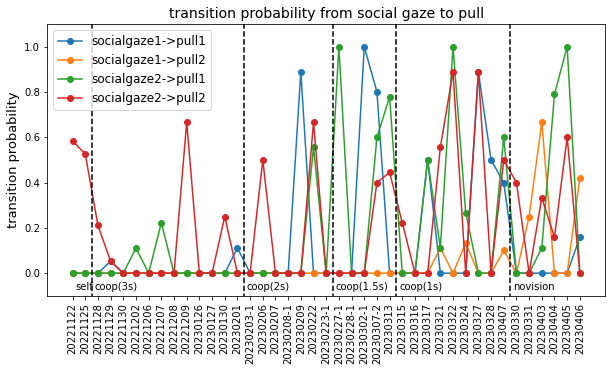

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type, cooperation threshold and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,2,0],'o-',label = "socialgaze1->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,2,1],'o-',label = "socialgaze1->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,3,0],'o-',label = "socialgaze2->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,3,1],'o-',label = "socialgaze2->pull2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to pull", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

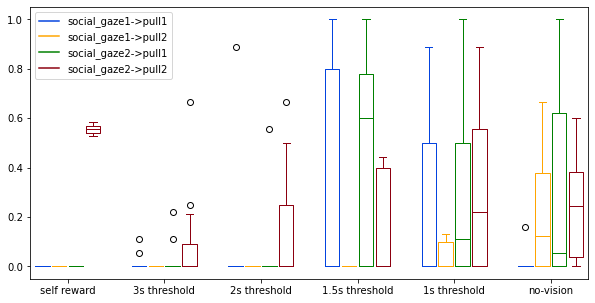

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','no-vision']

gaze1_pull1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],2,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==-1)[0],2,0]]
gaze1_pull2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],2,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==-1)[0],2,1]]
gaze2_pull1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],3,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==-1)[0],3,0]]
gaze2_pull2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],3,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==-1)[0],3,1]
               ]
gaze1_pull1_plot = plt.boxplot(gaze1_pull1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
gaze1_pull2_plot = plt.boxplot(gaze1_pull2,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
gaze2_pull1_plot = plt.boxplot(gaze2_pull1,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
gaze2_pull2_plot = plt.boxplot(gaze2_pull2,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_pull1_plot, '#0343DF', 'social_gaze1->pull1')
define_box_properties(gaze1_pull2_plot, '#FFA500', 'social_gaze1->pull2')
define_box_properties(gaze2_pull1_plot, '#008000', 'social_gaze2->pull1')
define_box_properties(gaze2_pull2_plot, '#8C000F', 'social_gaze2->pull2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to social gaze

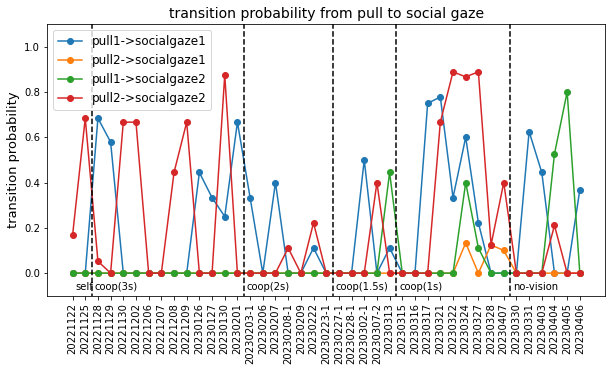

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,0,2],'o-',label = "pull1->socialgaze1")
ax1.plot(DAGs_all_dates[sorting_df.index,1,2],'o-',label = "pull2->socialgaze1")
ax1.plot(DAGs_all_dates[sorting_df.index,0,3],'o-',label = "pull1->socialgaze2")
ax1.plot(DAGs_all_dates[sorting_df.index,1,3],'o-',label = "pull2->socialgaze2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to social gaze", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

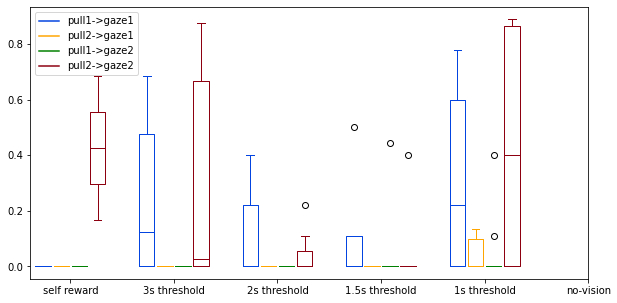

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','no-vision']

pull1_gaze1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],0,2]]
pull2_gaze1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],1,2]]
pull1_gaze2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],0,3]]
pull2_gaze2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],1,3]]

pull1_gaze1_plot = plt.boxplot(pull1_gaze1,positions=np.array(np.arange(len(pull1_gaze1)))*4.0-1.05,widths=0.6)
pull2_gaze1_plot = plt.boxplot(pull2_gaze1,positions=np.array(np.arange(len(pull2_gaze1)))*4.0-0.35,widths=0.6)
pull1_gaze2_plot = plt.boxplot(pull1_gaze2,positions=np.array(np.arange(len(pull1_gaze2)))*4.0+0.35,widths=0.6)
pull2_gaze2_plot = plt.boxplot(pull2_gaze2,positions=np.array(np.arange(len(pull2_gaze2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_gaze1_plot, '#0343DF', 'pull1->gaze1')
define_box_properties(pull2_gaze1_plot, '#FFA500', 'pull2->gaze1')
define_box_properties(pull1_gaze2_plot, '#008000', 'pull1->gaze2')
define_box_properties(pull2_gaze2_plot, '#8C000F', 'pull2->gaze2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to pull

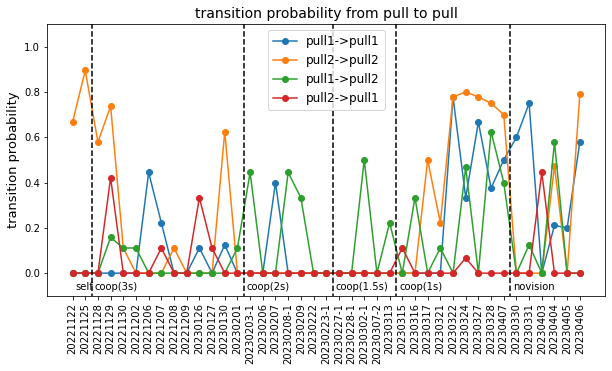

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,0,0],'o-',label = "pull1->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,1,1],'o-',label = "pull2->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,0,1],'o-',label = "pull1->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,1,0],'o-',label = "pull2->pull1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to pull", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

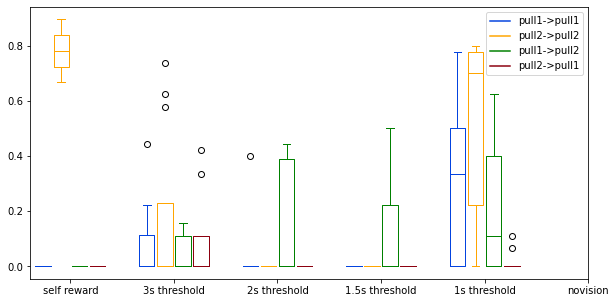

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

pull1_pull1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],0,0]]
pull2_pull2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],1,1]]
pull1_pull2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],0,1]]
pull2_pull1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],1,0]]
pull1_pull1_plot = plt.boxplot(pull1_pull1,positions=np.array(np.arange(len(pull1_pull1)))*4.0-1.05,widths=0.6)
pull2_pull2_plot = plt.boxplot(pull2_pull2,positions=np.array(np.arange(len(pull1_pull2)))*4.0-0.35,widths=0.6)
pull1_pull2_plot = plt.boxplot(pull1_pull2,positions=np.array(np.arange(len(pull2_pull1)))*4.0+0.35,widths=0.6)
pull2_pull1_plot = plt.boxplot(pull2_pull1,positions=np.array(np.arange(len(pull2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_pull1_plot, '#0343DF', 'pull1->pull1')
define_box_properties(pull2_pull2_plot, '#FFA500', 'pull2->pull2')
define_box_properties(pull1_pull2_plot, '#008000', 'pull1->pull2')
define_box_properties(pull2_pull1_plot, '#8C000F', 'pull2->pull1')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from social gaze to social gaze

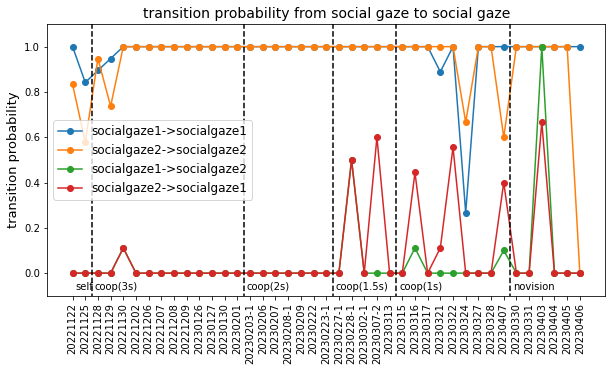

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,2,2],'o-',label = "socialgaze1->socialgaze1")
ax1.plot(DAGs_all_dates[sorting_df.index,3,3],'o-',label = "socialgaze2->socialgaze2")
ax1.plot(DAGs_all_dates[sorting_df.index,2,3],'o-',label = "socialgaze1->socialgaze2")
ax1.plot(DAGs_all_dates[sorting_df.index,3,2],'o-',label = "socialgaze2->socialgaze1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to social gaze", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

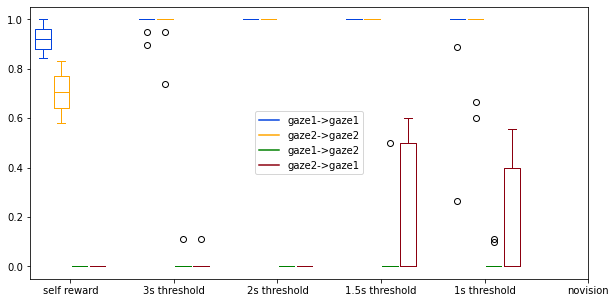

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

gaze1_gaze1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],2,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],2,2]]
gaze2_gaze2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],3,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],3,3]]
gaze1_gaze2 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],2,3],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],2,3]]
gaze2_gaze1 = [DAGs_all_dates[np.transpose(coopthres_forsort==100)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==3)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==2)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1.5)[0],3,2],
               DAGs_all_dates[np.transpose(coopthres_forsort==1)[0],3,2]]
gaze1_gaze1_plot = plt.boxplot(gaze1_gaze1,positions=np.array(np.arange(len(gaze1_gaze1)))*4.0-1.05,widths=0.6)
gaze2_gaze2_plot = plt.boxplot(gaze2_gaze2,positions=np.array(np.arange(len(gaze2_gaze2)))*4.0-0.35,widths=0.6)
gaze1_gaze2_plot = plt.boxplot(gaze1_gaze2,positions=np.array(np.arange(len(gaze1_gaze2)))*4.0+0.35,widths=0.6)
gaze2_gaze1_plot = plt.boxplot(gaze2_gaze1,positions=np.array(np.arange(len(gaze2_gaze1)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_gaze1_plot, '#0343DF', 'gaze1->gaze1')
define_box_properties(gaze2_gaze2_plot, '#FFA500', 'gaze2->gaze2')
define_box_properties(gaze1_gaze2_plot, '#008000', 'gaze1->gaze2')
define_box_properties(gaze2_gaze1_plot, '#8C000F', 'gaze2->gaze1')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot between behavioral measures - successful rate vs interpull interval

Text(0, 1, 'corr r = -0.13; corr p = 0.43')

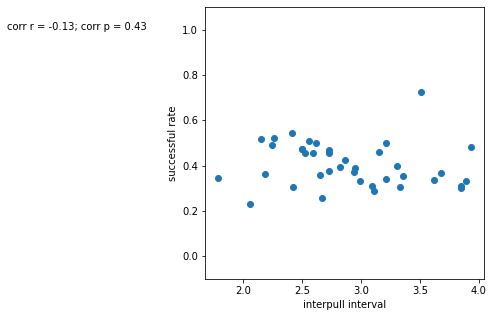

In [27]:
fig, axs = plt.subplots(1,1,figsize=(5, 5))

# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx = interpullintv_all_dates[ind]
yyy = succ_rate_all_dates[ind]
axs.plot(xxx,yyy,'o')
axs.set_xlabel('interpull interval')
axs.set_ylabel('successful rate')
# axs.set_xlim([-0.1,1.1])
axs.set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy)
axs.text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.01; corr p = 0.91')

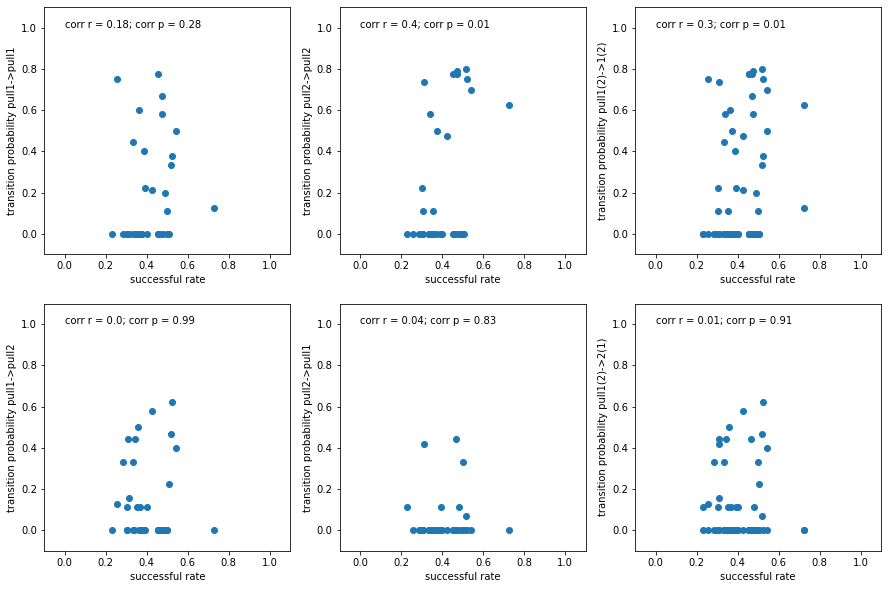

In [28]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)
#
xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull1(2)->2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - interpull interval

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx  = interpullintv_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('interpull interval')
axs[0,0].set_ylabel('transition probability '+y1label)
#axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('interpull interval')
axs[0,1].set_ylabel('transition probability '+y2label)
#axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('interpull interval')
axs[1,0].set_ylabel('transition probability '+y3label)
#axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('interpull interval')
axs[1,1].set_ylabel('transition probability '+y4label)
#axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('interpull interval')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
#axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('interpull interval')
axs[1,2].set_ylabel('transition probability pull2(1)->1(2)')
#axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.23; corr p = 0.04')

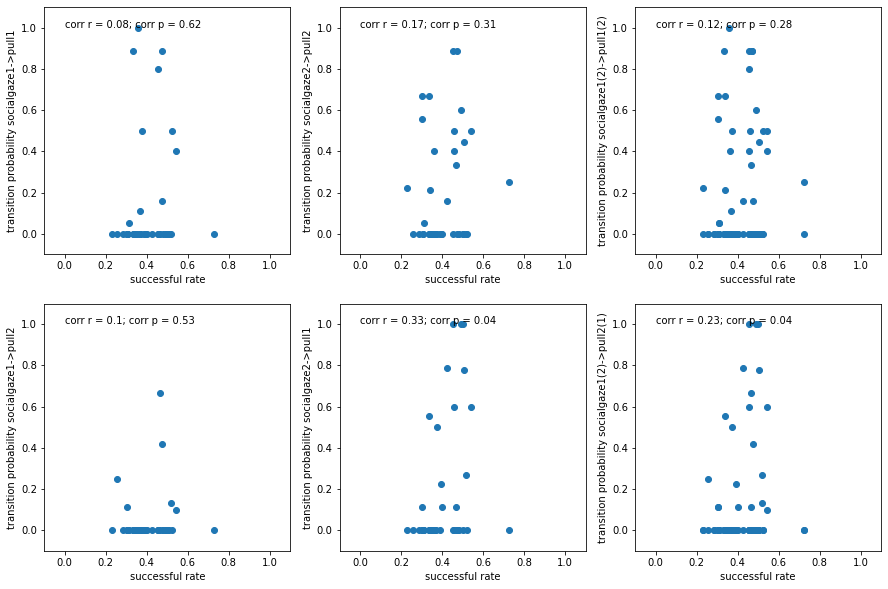

In [29]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,0]
y1label = "socialgaze1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,1]
y2label = "socialgaze2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,1]
y3label = "socialgaze1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,0]
y4label = "socialgaze2->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->pull1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability socialgaze1(2)->pull2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the pull -> gaze transition probability vs behavioral measures - successful rate

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,2]
y1label = "pull1->socialgaze1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,3]
y2label = "pull2->socialgaze2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],1,2]
y3label = "pull2->socialgaze1"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],0,3]
y4label = "pull1->socialgaze2"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->socialgaze1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull2(1)->socialgaze1(2)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze -> gaze transition probability vs behavioral measures - successful rate

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,2]
y1label = "socialgaze1->socialgaze1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,3]
y2label = "socialgaze2->socialgaze2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,3]
y3label = "socialgaze1->socialgaze2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,2]
y4label = "socialgaze2->socialgaze1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->socialgaze1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability socialgaze2(1)->socialgaze1(2)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs gaze/pull ratio

In [ ]:
#
# sort the data based on task type and dates
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#

gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(gaze_numbers[sorting_df.index],'o-',label = "all social gazes")

ax1.legend(fontsize=12)
ax1.set_ylabel("total social gaze numbers",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
ax2 = ax1.twinx()
ax2.plot(gaze_pull_ratios[sorting_df.index],'ro-',label = "gaze to pull ratio")
ax2.legend(fontsize=12)
ax2.set_ylabel("gaze to pull ratio",fontsize=13)
#
plt.show()

In [ ]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

gaze_numbers_groups = [np.transpose(gaze_pull_ratios[np.transpose(coopthres_forsort==100)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_forsort==3)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_forsort==2)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_forsort==1.5)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_forsort==1)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_forsort==-1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average gaze to pull ratio',fontsize = 15);

In [ ]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

gaze_numbers_groups = [np.transpose(gaze_numbers[np.transpose(coopthres_forsort==100)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==3)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==2)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==1.5)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==1)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==-1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average total gaze numbers',fontsize = 15);

In [ ]:
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)
# gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = gaze_pull_ratios[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,0]
y1label = "socialgaze1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,1]
y2label = "socialgaze2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,1]
y3label = "socialgaze1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,0]
y4label = "socialgaze2->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('gaze-pull ratios')
axs[0,0].set_ylabel('transition probability '+y1label)
# axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('gaze-pull ratios')
axs[0,1].set_ylabel('transition probability '+y2label)
# axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('gaze-pull ratios')
axs[1,0].set_ylabel('transition probability '+y3label)
# axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('gaze-pull ratios')
axs[1,1].set_ylabel('transition probability '+y4label)
# axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('gaze-pull ratios')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->pull1(2)')
# axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('gaze-pull ratios')
axs[1,2].set_ylabel('transition probability socialgaze1(2)->pull2(1)')
# axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))


